In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline  
from IPython.display import display, HTML

In [2]:
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score, precision_score, recall_score
import pandas
import numpy as np
import json
import matplotlib.pyplot as plt
import os
import ast
import seaborn
from db import Result
import math
import papermill as pm
from vis.utils.utils import load_img

from config import config
pandas.options.display.float_format = '{:,.3f}'.format

Using TensorFlow backend.


In [3]:
from evaluate import load, get_results, get_labels, transform_binary_probabilities, transform_binary_predictions, calculate_accuracy_loss, plot_confusion_matrix, plot_precision_recall, plot_roc_curve, calculate_pr_auc, calculate_confusion_matrix_stats, calculate_confusion_matrix, plot_tsne, accession_from_filename, plot_expert_confusion, plot_grad_cam, get_expert_results

In [4]:
from data import describe, all_features, data, print_describe, load_single
from run import characterize_data

# All models

In [5]:
CROPS = ["free", "fixed"]
SUBSETS = ["complete", "uncertain"]
DESCRIPTIONS = {
    ("free", "complete"): "complete-set-free-final-2",
    ("fixed", "complete"): "complete-set-fixed-final-2",
    ("free", "uncertain"): "c3-c4-free-final-2",
    ("fixed", "uncertain"): "c3-c4-fixed-final-2",
}
DATA_FOLDERS = {
    ("free", "complete"): "complete-set-free/data",
    ("fixed", "complete"): "complete-set-fixed/data",
    ("free", "uncertain"): "c3-c4-free/data",
    ("fixed", "uncertain"): "c3-c4-fixed/data",
}

In [6]:
for crop in CROPS: 
    for subset in SUBSETS:
        results = Result.query.filter(Result.description == DESCRIPTIONS[(crop, subset)]).all()
        pd = pandas.DataFrame([{
            "accuracy": r.accuracy, 
            "train_accuracy": r.train_accuracy, 
            "uuid": r.uuid
        } for r in results])
        #print(crop, subset)
        #print(pd.nlargest(10, "accuracy"))

In [7]:
UUIDS = {
    ("free", "complete"): "3f408cc9-5eef-414e-8cd7-041fabd9297a",
    ("free", "uncertain"): "1b356a9e-126c-4f91-8f41-8d6baa4f79de",
    ("fixed", "complete"): "08d46f34-4836-4e7c-a240-a0a1c4233093",
    ("fixed", "uncertain"): "f38c310c-d46f-4136-89d8-2a39261c0e0e",
}

In [8]:
PROBABILITIES = dict()
DATASETS = dict()
STATS = dict()
EXPERT1_STATS = dict()
EXPERT2_STATS = dict()
ALL = dict()
RESULT = dict()
CORRECT_INCORRECT = dict()
for crop in CROPS: 
    for subset in SUBSETS:
        display(HTML("<h4>{}-{}</h4>".format(crop, subset)))
        result = Result.query.filter(Result.uuid == UUIDS[(crop, subset)]).first()
        dataset = load_single("{}/validation".format(DATA_FOLDERS[(crop, subset)]))
        probabilities = np.array(ast.literal_eval(result.probabilities))
        predictions = transform_binary_predictions(probabilities)
        stats = calculate_confusion_matrix_stats(get_labels(dataset), probabilities)
        expert1_results = np.array([dataset.class_indices.get(i, 0) for i in get_expert_results("evaluations/radiology-9809.json", dataset.filenames)])
        expert2_results = np.array([dataset.class_indices.get(i, 0) for i in get_expert_results("evaluations/radiology-9809.json", dataset.filenames)])
        expert1_stats = calculate_confusion_matrix_stats(get_labels(dataset), expert1_results)
        expert2_stats = calculate_confusion_matrix_stats(get_labels(dataset), expert2_results)
        malignancy, modality, category = all_features(features="{}/features.csv".format(DATA_FOLDERS[(crop, subset)]))
        category_labels = [category.get(accession_from_filename(f), f) for f in dataset.filenames]
        RESULT[(crop, subset)] = result
        ALL[(crop, subset)] = pandas.DataFrame({
            "code_abdomen": category_labels,
            "probabilities": probabilities, 
            "expert1": expert1_results, 
            "expert2": expert2_results,
            "labels": get_labels(dataset),
        }) 
        CORRECT_INCORRECT[(crop, subset)] = { dataset.filenames[i]: (dataset.classes[i], predictions[i]) for i, _ in enumerate(dataset.filenames) }
        DATASETS[(crop, subset)] = dataset
        PROBABILITIES[(crop, subset)] = probabilities
        STATS[(crop, subset)] = stats
        EXPERT1_STATS[(crop, subset)] = expert1_stats
        EXPERT2_STATS[(crop, subset)] = expert2_stats
        display(HTML(pandas.DataFrame.from_dict({
            "model": pandas.DataFrame(stats).iloc[1],
            "expert 1": pandas.DataFrame(expert1_stats).iloc[1],
            "expert 2": pandas.DataFrame(expert2_stats).iloc[1],
        }, orient="index").to_html()))

Found 102 images belonging to 2 classes.
error with benign/free-27244981-liver.jpeg: '27244981-liver.jpeg'
error with benign/free-27244981-liver.jpeg: '27244981-liver.jpeg'


Found 47 images belonging to 2 classes.
error with benign/free-27741572-liver.jpeg: '27741572-liver.jpeg'
error with benign/free-27741572-liver.jpeg: '27741572-liver.jpeg'


Found 104 images belonging to 2 classes.
error with benign/fixed-27244981-liver.jpeg: '27244981-liver.jpeg'
error with benign/fixed-27244981-liver.jpeg: '27244981-liver.jpeg'


Found 48 images belonging to 2 classes.


  code  expert1  expert2  model
0   C2    0.933    0.933  0.867
1   C3    0.769    0.769  0.821
2   C4    0.529    0.529  0.882
3   C5    0.750    0.750  0.750


/home/harrison/intrepidlemon/deep-ultrasound/evaluate.py:85: RuntimeWarning: invalid value encountered in true_divide
  TPR = TP/(TP+FN)
/home/harrison/intrepidlemon/deep-ultrasound/evaluate.py:87: RuntimeWarning: invalid value encountered in true_divide
  TNR = TN/(TN+FP)
/home/harrison/intrepidlemon/deep-ultrasound/evaluate.py:93: RuntimeWarning: invalid value encountered in true_divide
  FPR = FP/(FP+TN)
/home/harrison/intrepidlemon/deep-ultrasound/evaluate.py:95: RuntimeWarning: invalid value encountered in true_divide
  FNR = FN/(TP+FN)


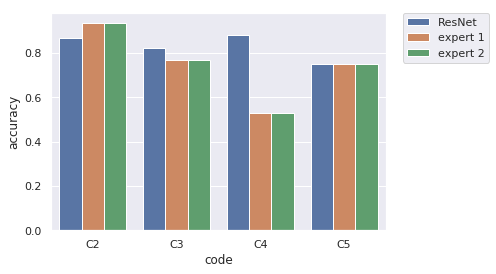

  code  expert1  expert2  model
0   C3    0.758    0.758  0.939
1   C4    0.714    0.714  0.643


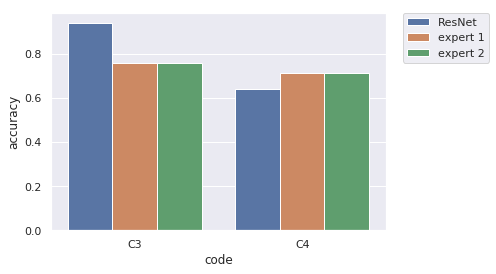

  code  expert1  expert2  model
0   C2    0.743    0.743  0.971
1   C3    0.579    0.579  0.895
2   C4    0.375    0.375  0.375
3   C5    0.609    0.609  0.174


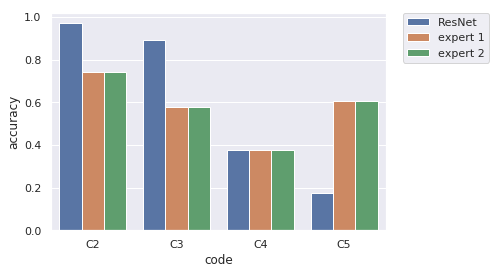

  code  expert1  expert2  model
0   C3    0.686    0.686  0.914
1   C4    0.769    0.769  0.615


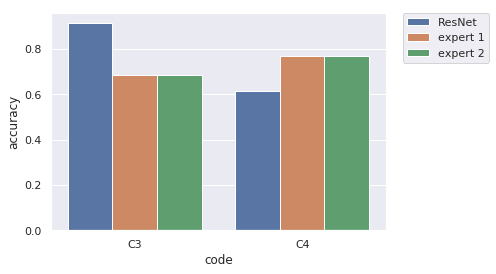

In [9]:
def get_acc(labels, probabilities): 
    stats = calculate_confusion_matrix_stats(labels, probabilities)
    return stats["Acc"][1]

for crop in CROPS: 
    for subset in SUBSETS:
        display(HTML("<h4>{}-{}</h4>".format(crop, subset)))
        results = ALL[(crop, subset)]
        accuracy_by_code = list()
        accuracy_list = list()
        for code in np.unique(results.code_abdomen): 
            pd = results[results.code_abdomen == code]
            model = get_acc(pd["labels"].values, pd["probabilities"].values)
            expert1 = get_acc(pd["labels"].values, pd["expert1"].values)
            expert2 = get_acc(pd["labels"].values, pd["expert2"].values)
            accuracy_list.append({
                "code": code, 
                "model": "ResNet", 
                "accuracy": model, 
            })
            accuracy_list.append({
                "code": code, 
                "model": "expert 1", 
                "accuracy": expert1, 
            })
            accuracy_list.append({
                "code": code, 
                "model": "expert 2", 
                "accuracy": expert2, 
            })                
            accuracy_by_code.append({
                "code": code, 
                "model": model, 
                "expert1": expert1, 
                "expert2": expert2,
            })
        print(pandas.DataFrame(accuracy_by_code))
        seaborn.barplot(data=pandas.DataFrame(accuracy_list), x="code", y="accuracy", hue="model")
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.show()

# Image visualizations

/home/harrison/.local/share/virtualenvs/deep-ultrasound-k5cplrX3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/harrison/.local/share/virtualenvs/deep-ultrasound-k5cplrX3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


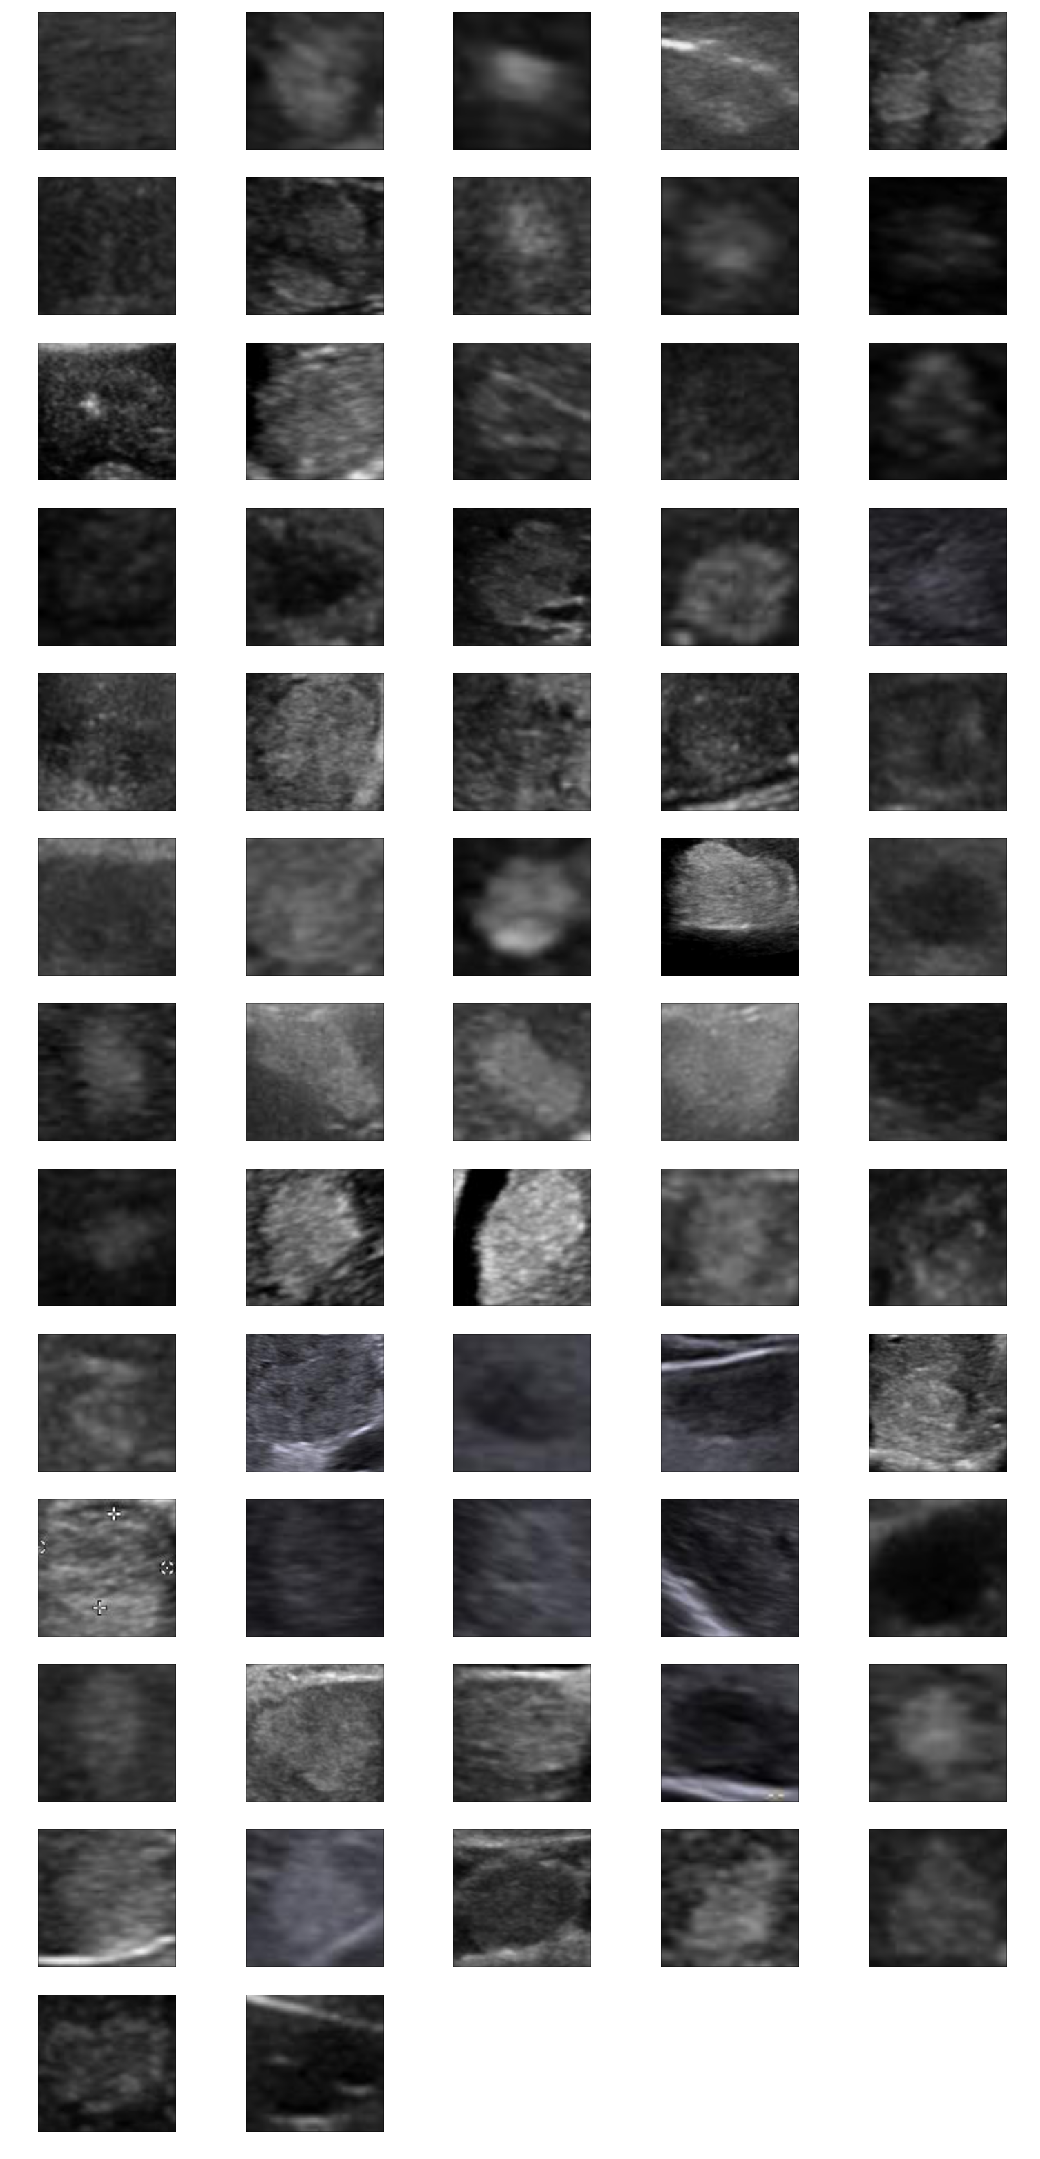

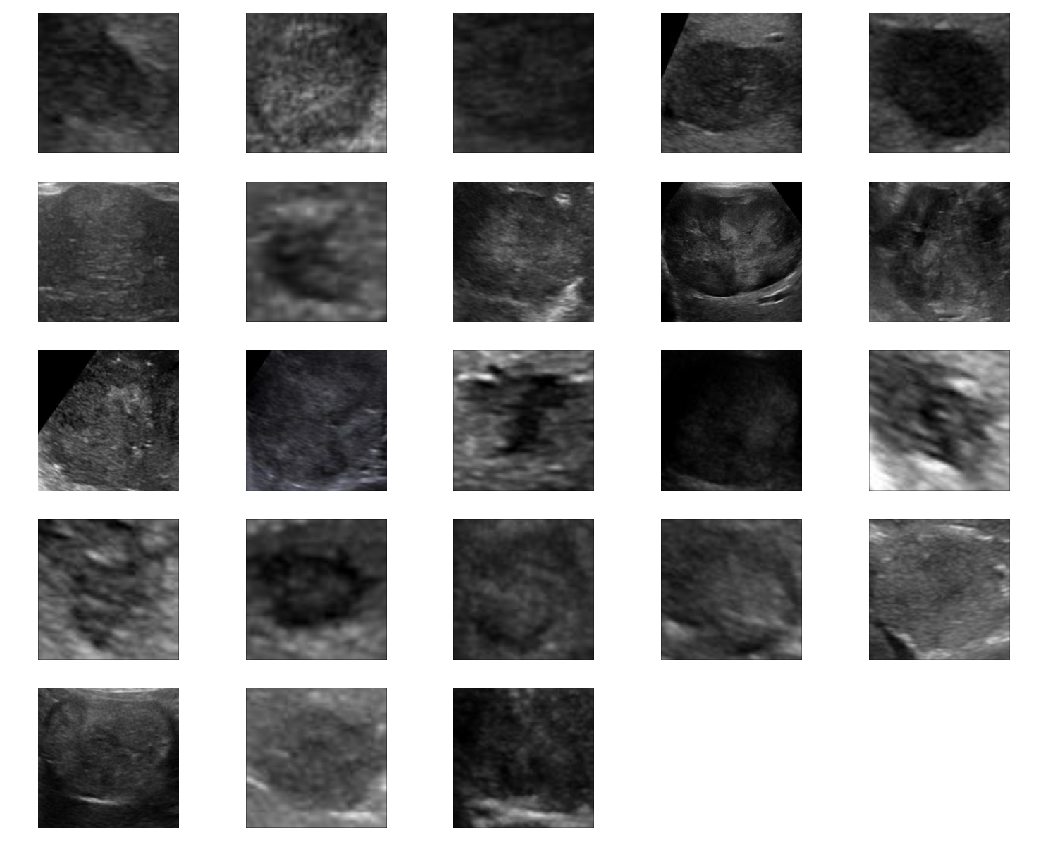

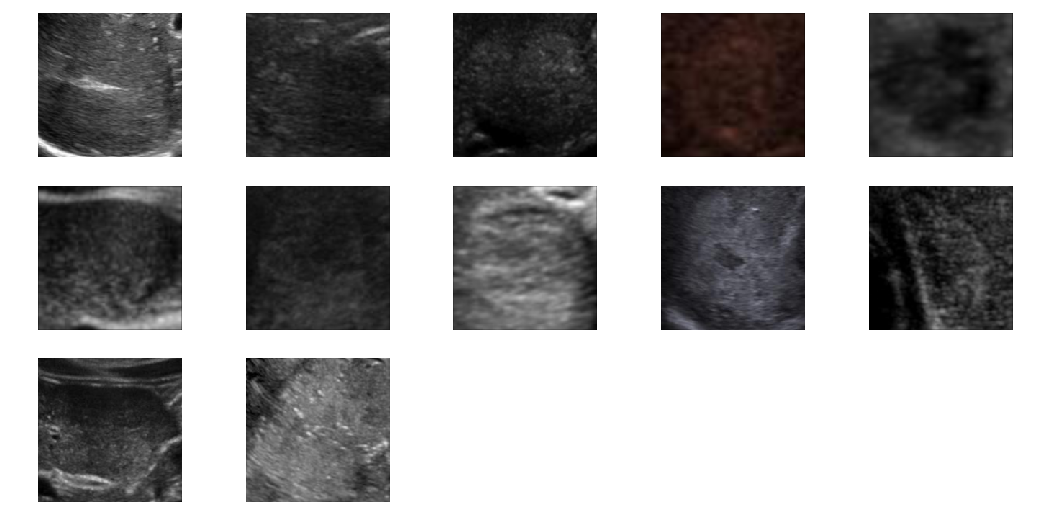

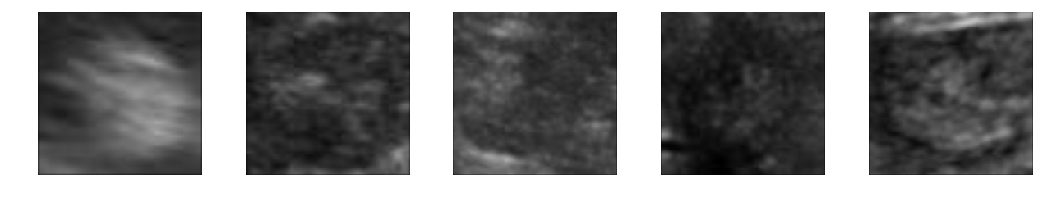

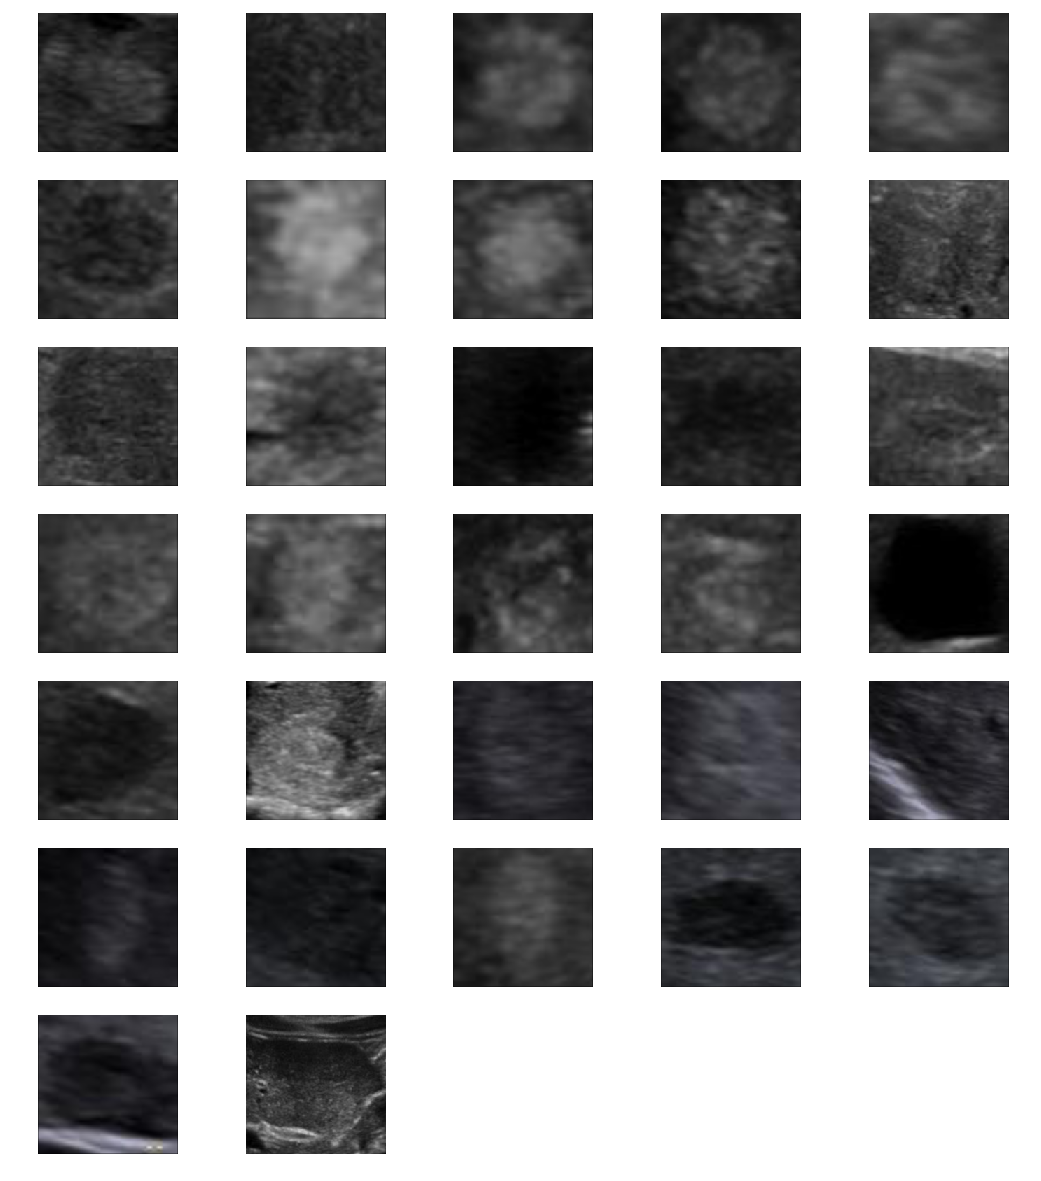

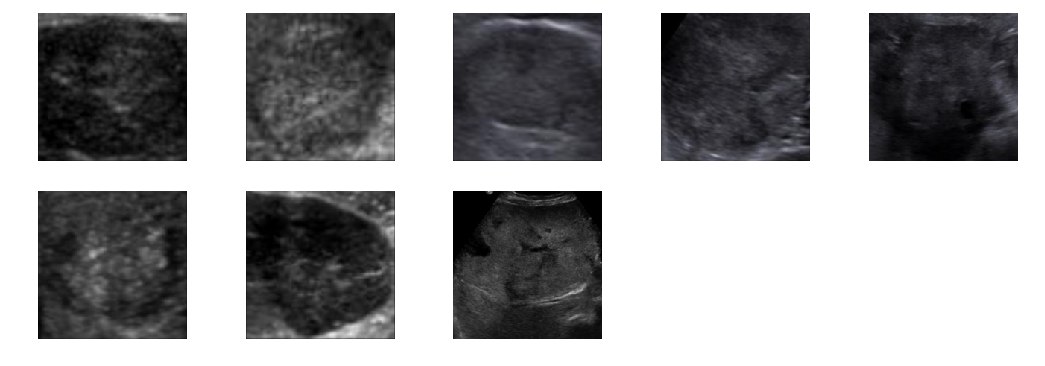

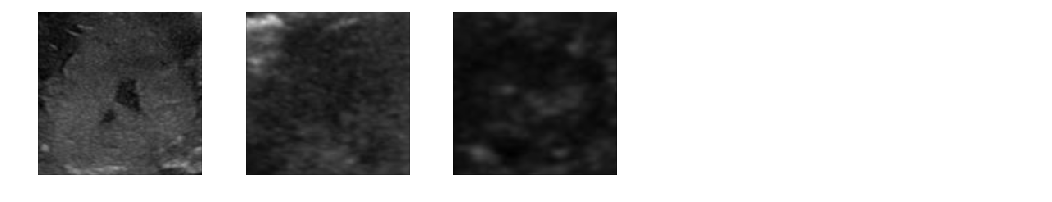

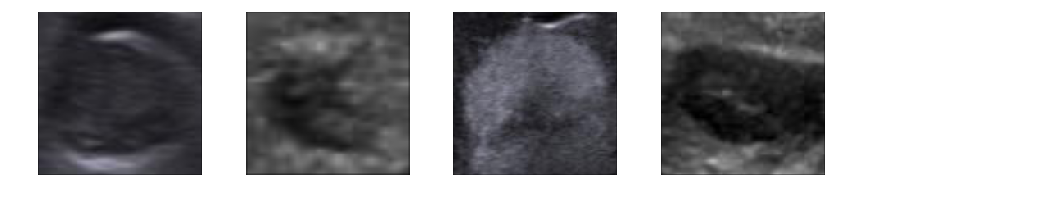

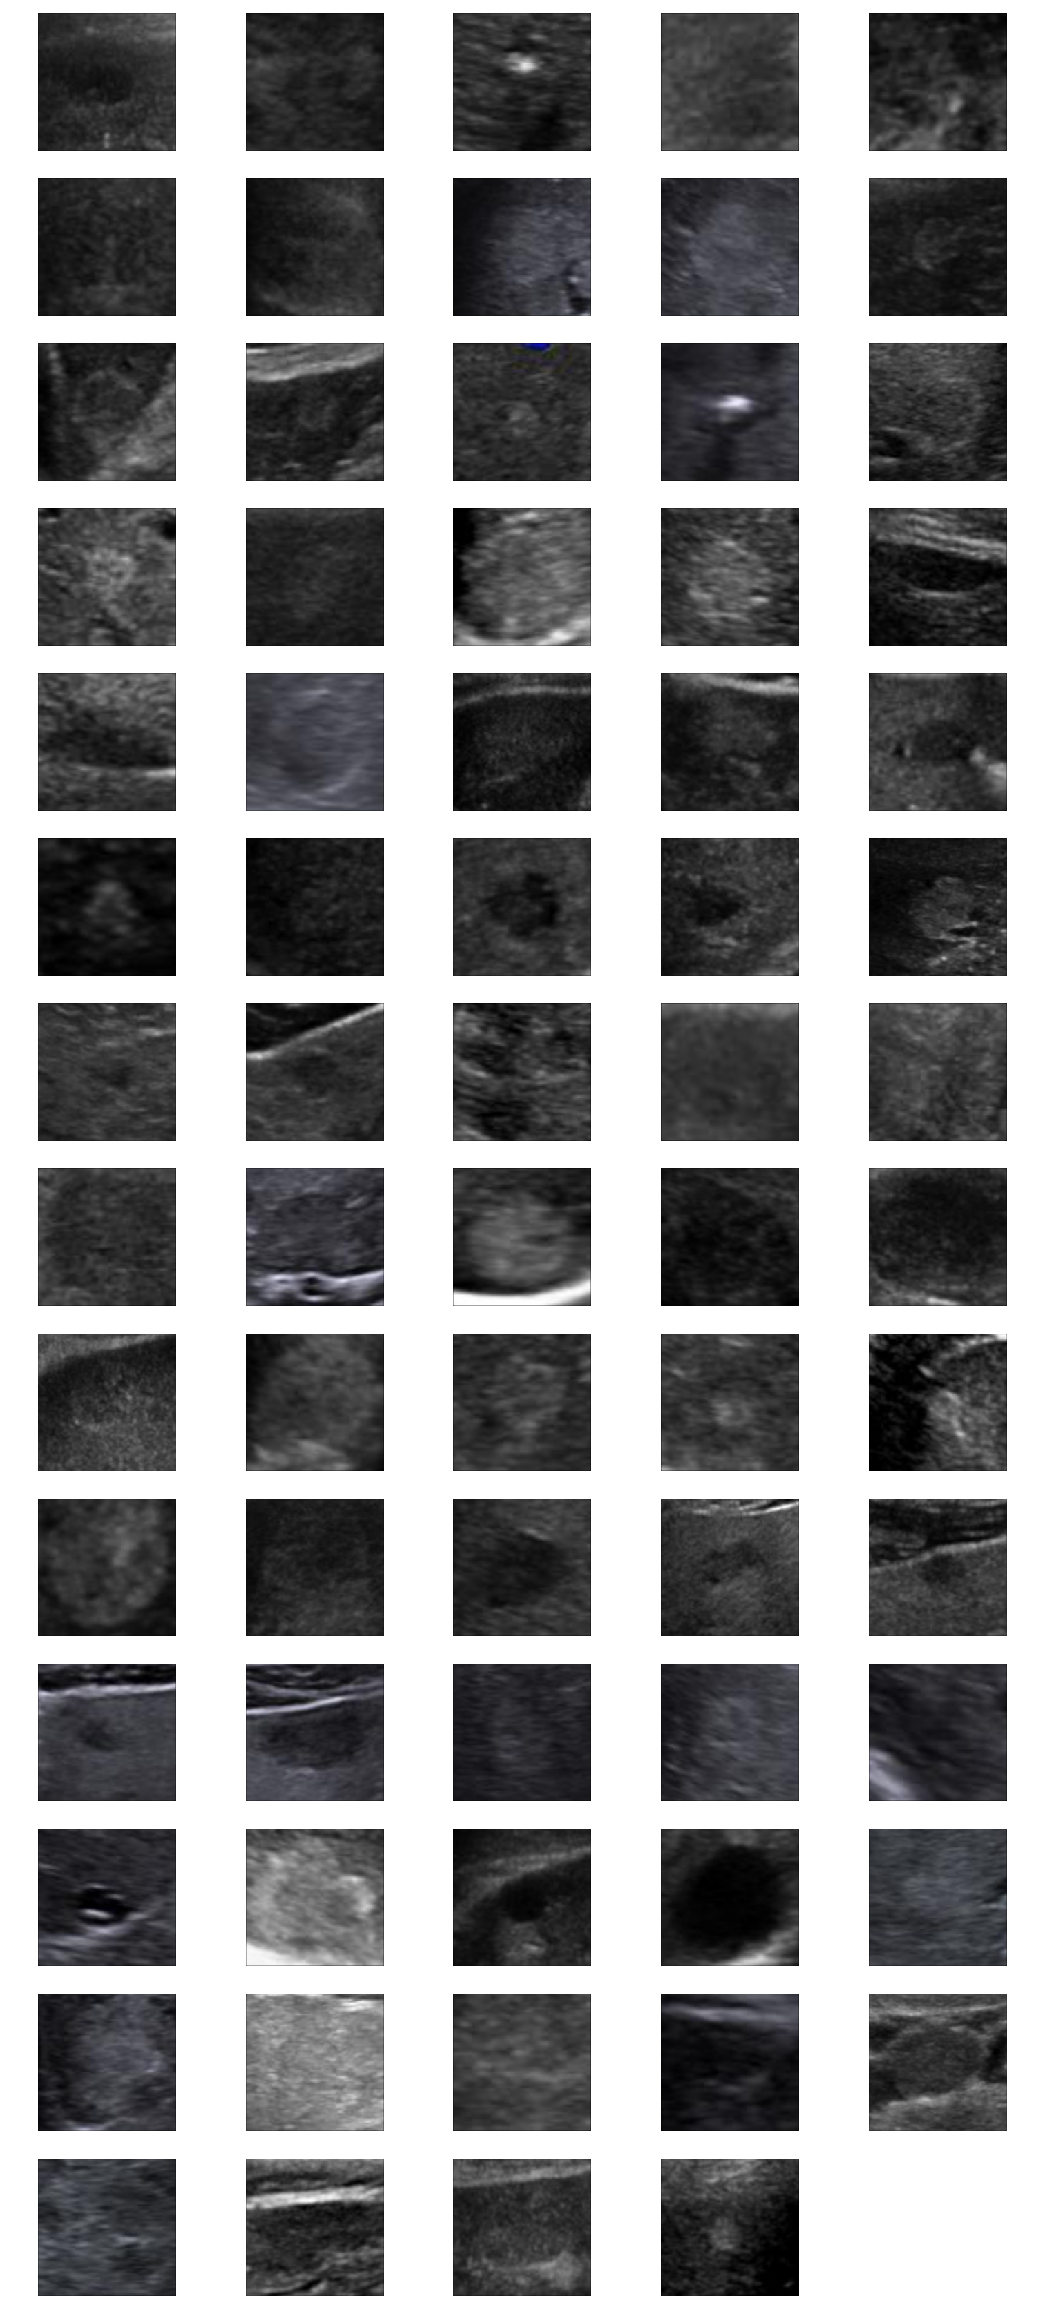

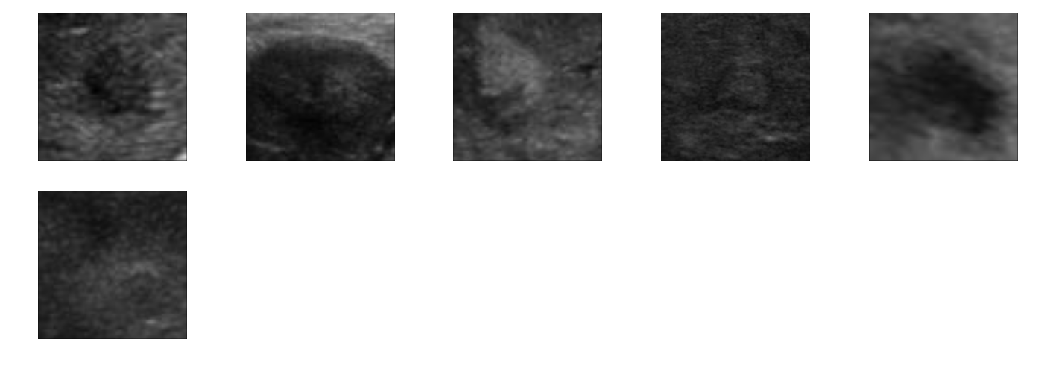

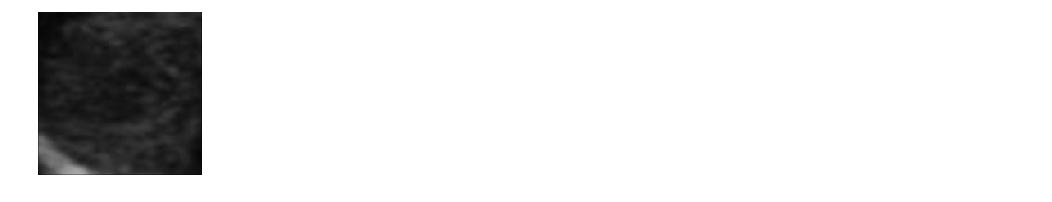

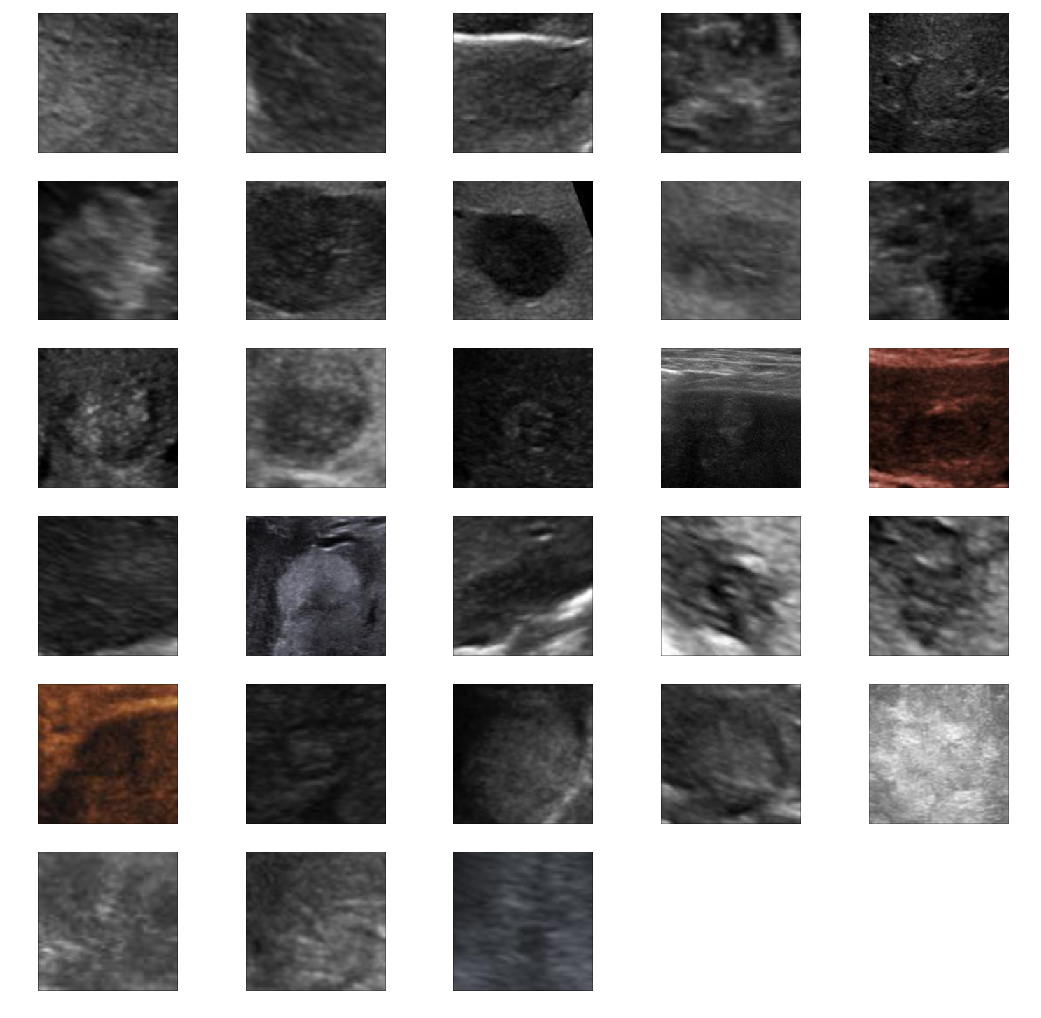

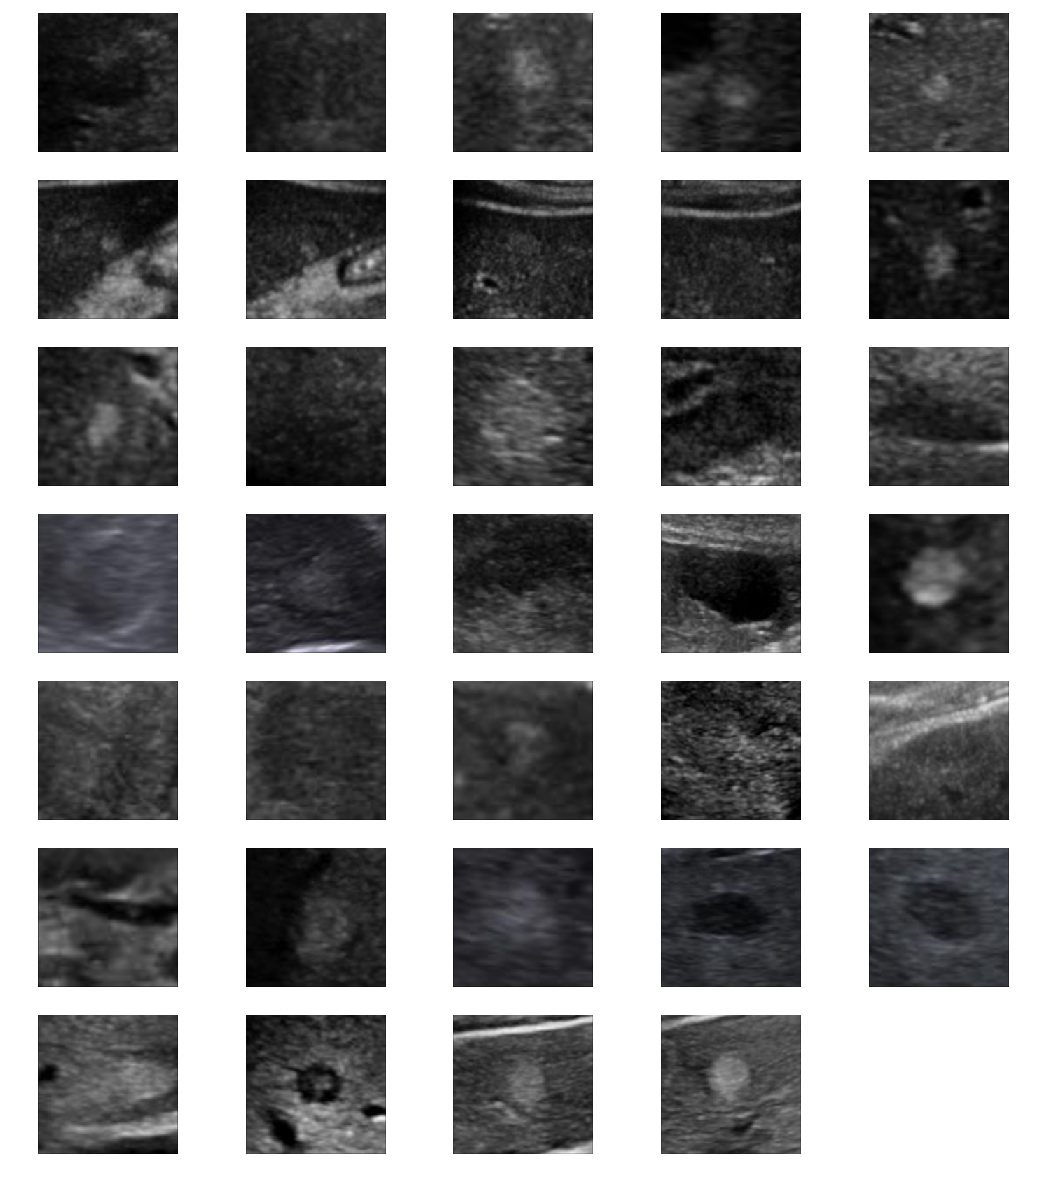

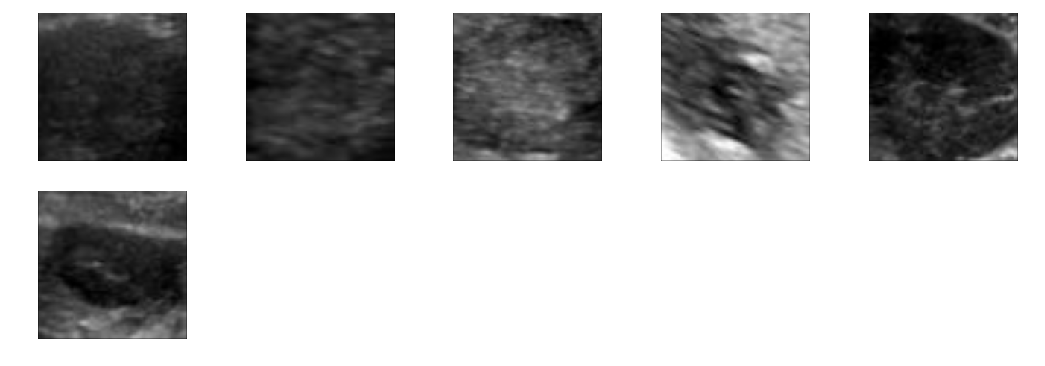

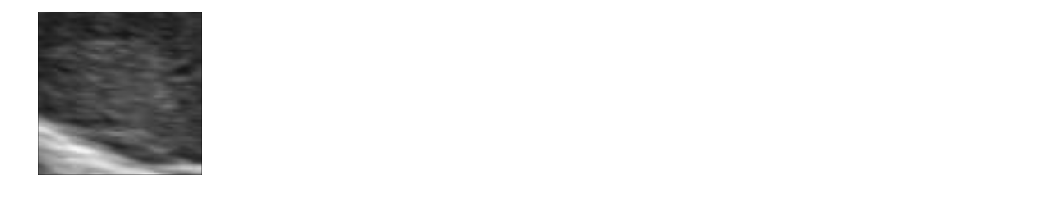

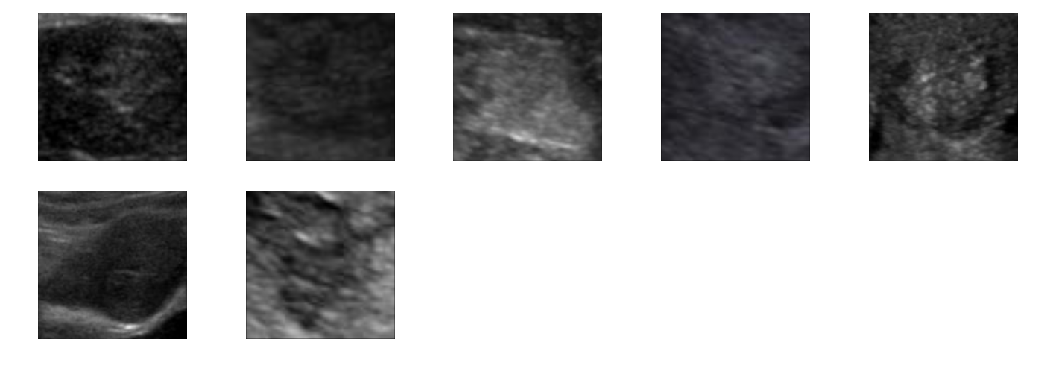

In [10]:
COLUMNS = 5
# from harrison
selection_index = {
    ("free", "uncertain"): {
        (0, 0): [1, 7, 28], 
        (0, 1): [0],
        (1, 0): [0, 1, 2, 3],
        (1, 1): [1, 2, 6],
    }, 
}
selection = { (crop, subset): dict() for crop in CROPS for subset in SUBSETS } 
for crop in CROPS: 
    for subset in SUBSETS:
        display(HTML("<h3>{}-{}</h3>".format(crop, subset)))
        correct_incorrect = CORRECT_INCORRECT[(crop, subset)]
        by_correctness = {
            (0, 0): list(), 
            (1, 1): list(), 
            (0, 1): list(), 
            (1, 0): list(),
        }
        dataset = DATASETS[(crop, subset)]
        inv_indices = {v: k for k, v in dataset.class_indices.items()}
        for k, v in correct_incorrect.items(): 
            by_correctness[v].append(k)
        for k, v in by_correctness.items():
            display(HTML("<h5>diagnosis: {} | prediction: {}</h5>".format(inv_indices[k[0]], inv_indices[k[1]])))
            rows = int(math.ceil(len(v)/COLUMNS))
            f, ax = plt.subplots(rows, COLUMNS, figsize=(18, 3 * rows))
            ax = ax.flatten()
            selection_indices = selection_index.get((crop, subset), dict()).get((k[0], k[1]), list())
            selection[(crop, subset)][(k[0], k[1])] = [v[i] for i in selection_indices]
            for i, filename in enumerate(v): 
                image_file = "{}/validation/{}".format(DATA_FOLDERS[(crop, subset)], filename)
                image = load_img(image_file, target_size=(config.IMAGE_SIZE, config.IMAGE_SIZE))
                m = filename.split("-")
                m.pop(0)
                accession = m.pop(0)
                accession = accession.split("/")[0]
            #    print("https://cf151f9a.ngrok.io/{}/{}".format(accession, "-".join(m)))
                ax[i].imshow(image)
            for a in ax: 
                a.axis('off')
            plt.show()

# Evaluate all models

In [11]:
for crop in CROPS: 
    for subset in SUBSETS:
        pm.execute_notebook(
            "evaluate-specific-model.ipynb",
            "evaluate-{}-{}.ipynb".format(crop, subset),
            parameters = dict(
                DIRECTORY = DATA_FOLDERS[(crop, subset)],
                MODEL_UUID = UUIDS[(crop, subset)],
                MODEL_TYPE = RESULT[(crop, subset)].model,
                SELECTIONS = str(selection[(crop, subset)]),
            ),
        )

Input Notebook:  evaluate-specific-model.ipynb
Output Notebook: evaluate-free-complete.ipynb
100%|██████████| 43/43 [00:19<00:00,  2.25it/s]
Input Notebook:  evaluate-specific-model.ipynb
Output Notebook: evaluate-free-uncertain.ipynb
100%|██████████| 43/43 [00:47<00:00,  1.11s/it]
Input Notebook:  evaluate-specific-model.ipynb
Output Notebook: evaluate-fixed-complete.ipynb
100%|██████████| 43/43 [00:19<00:00,  2.20it/s]
Input Notebook:  evaluate-specific-model.ipynb
Output Notebook: evaluate-fixed-uncertain.ipynb
100%|██████████| 43/43 [00:17<00:00,  2.47it/s]


In [12]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')